In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output


In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
#Data Processing
#First, we will normalize the pixel values in the range of [0,1]. For this, we will divide each pixel value by 255. The dataset included from the TensorFlow is already divided into train and test split. 

In [3]:
def normalize(input_image, input_mask):

	# Normalize the pixel range values between [0:1]
	img = tf.cast(input_image, dtype=tf.float32) / 255.0
	input_mask -= 1
	return img, input_mask

@tf.function
def load_train_ds(dataset):
	img = tf.image.resize(dataset['image'], 
						size=(width, height))
	mask = tf.image.resize(dataset['segmentation_mask'],
						size=(width, height))

	if tf.random.uniform(()) > 0.5:
		img = tf.image.flip_left_right(img)
		mask = tf.image.flip_left_right(mask)

	img, mask = normalize(img, mask)
	return img, mask

@tf.function
def load_test_ds(dataset):
	img = tf.image.resize(dataset['image'], 
						size=(width, height))
	mask = tf.image.resize(dataset['segmentation_mask'], 
						size=(width, height))

	img, mask = normalize(img, mask)
	return img, mask


In [5]:
#Now we will set some constant values such as Buffer size, input height and width, etc.


TRAIN_LENGTH = info.splits['train'].num_examples

# Batch size is the number of examples used in one training example.
# It is mostly a power of 2
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# For VGG16 this is the input size
width, height = 224, 224


In [6]:
#Now, let’s load the train and test data into different variables and perform the data augmentation after batching is done.

train = dataset['train'].map(
	load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)

train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)


In [7]:
#Visualizing Data
#Visualize an image example and its corresponding mask from the dataset.

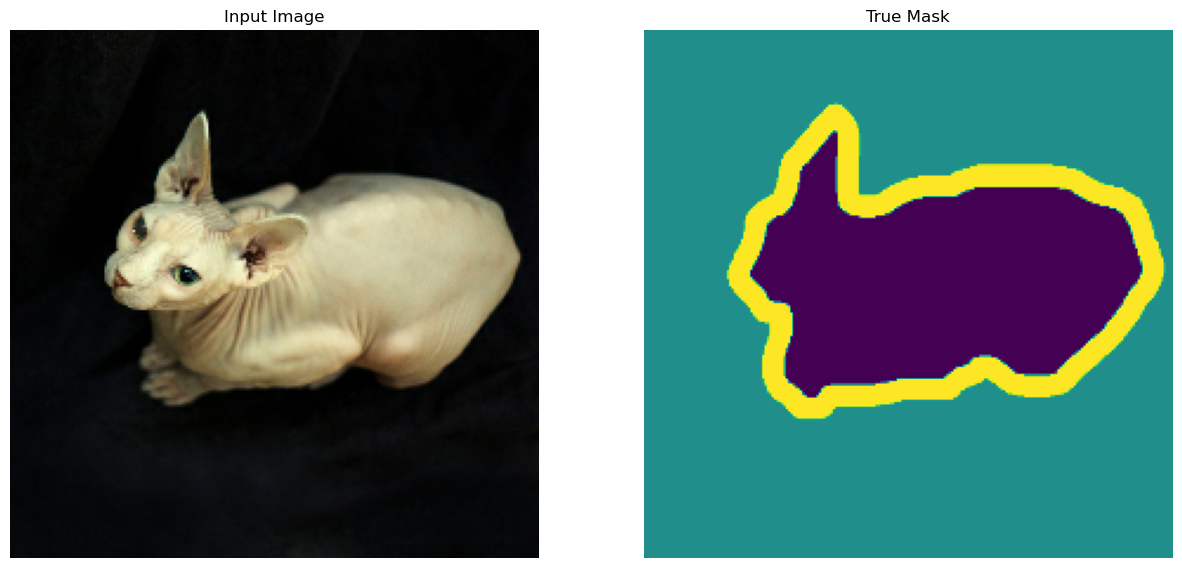

In [8]:
def display_images(display_list):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 
			'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
		plt.axis('off')

	plt.show()


for img, mask in train.take(1):
	sample_image, sample_mask = img, mask
	display_list = sample_image, sample_mask

display_images(display_list)


In [9]:
#U-Net
#U-Net is a CNN architecture used for most of the segmentation tasks. It consists of a contraction and expansion path which 
#gives it the name UNet. The contraction path consists of a convolution layer, followed by ReLu followed by max-pooling layers.
#Along the contraction path, the features get extracted and the spatial information is reduced. Along the expansion path, a 
#series of up convolutions along with concatenation of nigh resolution features are done from the contraction path. 

In [10]:
#For this project, we will use the encoder of the VGG16 model as it is already trained on the ImageNet dataset and has 
#learned some features. If the original UNet encoder is used it will learn everything from scratch and will take more time. 

In [11]:
base_model = keras.applications.vgg16.VGG16(
	include_top=False, input_shape=(width, height, 3))

layer_names = [
	'block1_pool',
	'block2_pool',
	'block3_pool',
	'block4_pool',
	'block5_pool',
]
base_model_outputs = [base_model.get_layer(
	name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
							base_model_outputs)


In [12]:
#Now define the decoder

def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same', 
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same', 
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu', 
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2), 
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu', 
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o


In [13]:
#Combining everything and creating a final model and compiling it



In [14]:
def segmentation_model():

	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(
				from_logits=True),
			metrics=['accuracy'])


In [15]:
#Creating prediction mask utility
#We will generate a function which will show us the real image its true mask and the predicted mask in a single row. 
#It is more of a visualization utility function

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


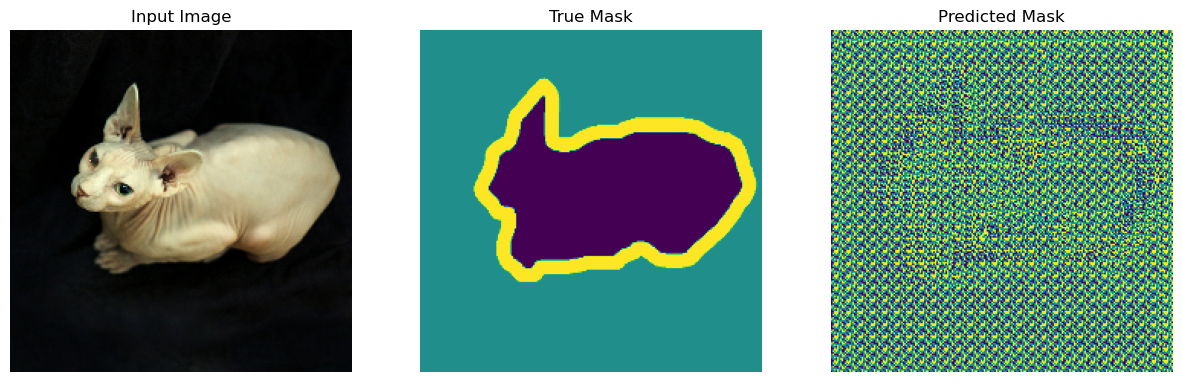

In [16]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]


def show_predictions(dataset=None, num=1):
	if dataset:
		for image, mask in dataset.take(num):
			pred_mask = model.predict(image)
			display_images([image[0], mask[0], create_mask(pred_mask)])
	else:
		display_images([sample_image, sample_mask,
						create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions()


In [17]:
#Training
#As all the required functions along with the model are created now we will train the model. We will train the model 
#for 20 epochs and perform a validation split of 5.

In [4]:
import tensorflow as tf

# Assuming you have defined your model architecture

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Assuming you have defined your train and test datasets as train_ds and test_ds

# Train the model
model_history = model.fit(train_ds, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_ds)


NameError: name 'BATCH_SIZE' is not defined

In [ ]:
#Metrics
#For the segmentation task, 2 types of metrics are considered. The first one is the Intersection over Union(IOU) and dice score. The formulas for each of them are as follows:

#IOU = \frac{Area of overlap}{Are of Union}    and DiceScore = 2*\frac{Area of Overlap}{Combined Area}

#IoU is the area of overlap between predicted segmentation and real mask divided by the union of the two.

In [ ]:
def compute_metrics(y_true, y_pred):
	'''
	Computes IOU and Dice Score.

	Args:
	y_true (tensor) - ground truth label map
	y_pred (tensor) - predicted label map
	'''

	class_wise_iou = []
	class_wise_dice_score = []

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))
		y_pred_area = np.sum((y_pred == i))
		combined_area = y_true_area + y_pred_area

		iou = (intersection + smoothening_factor) / \
			(combined_area - intersection + smoothening_factor)
		class_wise_iou.append(iou)

		dice_score = 2 * ((intersection + smoothening_factor) /
						(combined_area + smoothening_factor))
		class_wise_dice_score.append(dice_score)

	return class_wise_iou, class_wise_dice_score


In [ ]:
#Model Prediction with Metrics


def get_test_image_and_annotation_arrays():
	'''
	Unpacks the test dataset and returns
	the input images and segmentation masks
	'''

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape


def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
	plt.show()


iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)


In [ ]:
#Hence, we have finally performed Image segmentation using TensorFlow with the Oxford IIIT pet dataset.